# Capstone Project - Car sharing and neighborhoods in Milan, Italy.

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

I'll try to suggest potential stakeholders locations where to install **new parking areas for car sharing**, in the city of Milan, Italy. 

I'll be looking into neighborhoods which are **as close as possible to the city center**. Assuming this condition is met, I'll seek neighborhoods which are **less dense of parking areas for car sharing**. I'll also highlight neighborhoods with **lower real estate value**.

I'l use my data science knowledge to generate a few but promissing neighborhoods based on the criteria. The stakeholders will have a list of clustered neighborhoods to consider for further analysis.

## Data <a name="data"></a>

Based on definition of the problem, factors that will influence my decision are:
* distance of neighborhood from the city center **(~3Km)**
* number of existing parking areas for car sharing in the range of 300m from the neighborhood **(max 1)**

The sources I'll need to extract/generate the required information:
* The website **Immobiliare** (www.immobiliare.it) publishes real estate values for Italy, aggregated from the regions through borough down to the street level. It will be used to find the neighborhoods and the related real estate index.
* **Openstreetmap Nominatim API for geocoding**, to find the neighborhoods’ latitude and longitude, and the coordinates of Milan center.
* The**Foursquare API** used to retrieve the list of venues for the selected neighborhoods.
* The **open dataset portal of the Municipality of Milan** (https://dati.comune.milano.it/dataset) will be used to find the parking areas for car sharing.



In [10]:
#installing the required libraries

!conda install -c conda-forge geopy --yes
!pip install lxml
!pip install folium
!pip install pyproj
#!conda install -c conda-forge folium=0.5.0 --yes

import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim
import requests

import folium
from folium import plugins
from folium.plugins import HeatMap

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
%matplotlib inline 

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import pyproj
import math

Solving environment: done

# All requested packages already installed.



### Neighborhoods

I first create the **coordinates of the city center in Milan, using the Openstreetmap Nominatim API**. I'll also save the city Id in Openstreetmap for later use.

In [11]:
url='https://nominatim.openstreetmap.org/search?city=Milano&country=it&format=json'
response=requests.get(url).json()
milan_center=[]
osmid=[]
osmid.append(response[0]['osm_id'])
milan_center.append(float(response[0]['lat'])) #make lat and lon float for later use
milan_center.append(float(response[0]['lon']))
print('Coordinates of Milan center: {}, {}'.format(milan_center[0],milan_center[1]))

Coordinates of Milan center: 45.4668, 9.1905


I now need to **obtain a list of neighborhoods in Milan, and their latitude and longitude**. I first **scrap the data** from the Immobiliare website, and I using the Nominatim API I obtain the coordinates. Using the **Nominatim reverse search** I obtain the Zip code. I finally merge all the information into a dataframe df_neighborhoods. The dataframe merges together the Neighborhoods, their Zip code, latitude, longitude, and real estate Index. I save the results in a csv file.

In [12]:
try:
    df_neighborhoods = pd.read_csv('Milan_neigborhoods.csv')
    df_neighborhoods.drop(['Unnamed: 0'],axis=1,inplace=True)
    print('dataset imported')
    
except:      
    try:
        df_immobiliare = pd.read_csv('Milan_zones_immobiliare.csv')
    except:
        url= 'https://www.immobiliare.it/mercato-immobiliare/lombardia/milano'
        ls = pd.read_html(url,flavor='lxml')
        df_immobiliare=pd.DataFrame(ls[0])
        print('dataset downloaded','\n')
        df_immobiliare.to_csv('Milan_zones_immobiliare.csv')
        
    

    Zones=[]
    RE_indexs = []
    for zone,re_index in df_immobiliare[['Zone','Vendita (€/m²)']].values:
        for i in range(len(zone.split(','))):
            Zones.append(zone.split(',')[i].strip())
            RE_indexs.append(re_index)

    Addresses=[]
    Osm_ids=[]
    Osm_types=[]
    Latitudes=[]
    Longitudes=[]
    Postcodes=[]
  
    for zone in Zones:
        url='https://nominatim.openstreetmap.org/search?q={},Milano&city=Milano&country=it&format=json'.format(zone)
        response=requests.get(url).json()
        Addresses.append(response[0]['display_name'])
        Osm_ids.append(response[0]['osm_id'])
        Osm_types.append(response[0]['osm_type'])
        Latitudes.append(float(response[0]['lat']))
        Longitudes.append(float(response[0]['lon']))
        try:
            url2='https://nominatim.openstreetmap.org/reverse?lat={}&lon={}&format=json'.format(response[0]['lat'],response[0]['lon'])
            response=requests.get(url2).json()
            Postcodes.append(response['address']['postcode'])
        except:
            Postcodes.append('None')
            continue
            
        print(' .', end='')

    df_neighborhoods=pd.DataFrame({
        'Neighborhood':Zones,
        'Zip':Postcodes,
        'Latitude':Latitudes,
        'Longitude':Longitudes,
        'RE_index':RE_indexs
    })
        
    df_neighborhoods.to_csv('Milan_neigborhoods.csv')

df_neighborhoods.head()

dataset imported


,Neighborhood,Zip,Latitude,Longitude,RE_index
0,Centro,10122,45.466800,9.190500,9.947
1,Arco della Pace,20154,45.475692,9.172428,8.335
2,Arena,20121,45.475264,9.181564,8.335
3,Pagano,20145,45.468285,9.161100,8.335
4,Genova,20144,45.452879,9.169715,7.534


In [13]:
df_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  70 non-null     object 
 1   Zip           70 non-null     int64  
 2   Latitude      70 non-null     float64
 3   Longitude     70 non-null     float64
 4   RE_index      70 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


### Parking areas for car sharing

I read into a dataframe the **csv file about the parking areas for car sharing obtained from the open dataset portal of the Municipality of Milan**.

In [14]:
df_car_sharing = pd.read_csv('Milan_ds79_car_sh.csv',sep=';')
df_car_sharing.head()

,ID,AREA_SOSTA,LOCALIZ,ZONA,COMUNE,POSTI_AUTO,SERVIZIO,LONG_X_4326,LAT_Y_4326,Location
0,1001,Loreto/Mercadante,Via Mercadante davanti uscita M1 Argentina,3,MILANO,8,QUADRICICLI,9.214544,45.483351,"(45.4833510000071, 9.214544)"
1,1002,Pta Venezia,P.zza Oberdan uscita M1 ex casello (fronte Bas...,1,MILANO,8,QUADRICICLI,9.204847,45.473929,"(45.4739290000071, 9.204847)"
2,1003,Pagano,Via del Burchiello fronte parcheggio,7,MILANO,6,QUADRICICLI,9.160451,45.467845,"(45.4678450000071, 9.160451)"
3,1004,Cadorna,P.le Cadorna fronte civico 1/3,1,MILANO,8,QUADRICICLI,9.177717,45.466924,"(45.4669240000071, 9.177717)"
4,1005,Centrale Stazione,P.zza Duca d'Aosta davanti civico 16,2,MILANO,8,QUADRICICLI,9.205185,45.483864,"(45.4838640000071, 9.205185)"


I slice the dataframe and I assign English meaningful names to the columns.

In [15]:
df_car_sharing=df_car_sharing[['AREA_SOSTA','POSTI_AUTO','LOCALIZ','LAT_Y_4326','LONG_X_4326']]
df_car_sharing.columns=['Parking','Capacity','Address','Latitude','Longitude']
df_car_sharing.head()

,Parking,Capacity,Address,Latitude,Longitude
0,Loreto/Mercadante,8,Via Mercadante davanti uscita M1 Argentina,45.483351,9.214544
1,Pta Venezia,8,P.zza Oberdan uscita M1 ex casello (fronte Bas...,45.473929,9.204847
2,Pagano,6,Via del Burchiello fronte parcheggio,45.467845,9.160451
3,Cadorna,8,P.le Cadorna fronte civico 1/3,45.466924,9.177717
4,Centrale Stazione,8,P.zza Duca d'Aosta davanti civico 16,45.483864,9.205185


In [16]:
df_car_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Parking    113 non-null    object 
 1   Capacity   113 non-null    int64  
 2   Address    113 non-null    object 
 3   Latitude   113 non-null    float64
 4   Longitude  113 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ KB


In [17]:
map_milan = folium.Map(location=milan_center, zoom_start=13)
folium.Marker(milan_center, popup='centro').add_to(map_milan)

latlons_car_sharing = [[lat, lon] for lat, lon in df_car_sharing[['Latitude','Longitude']].values]
HeatMap(latlons_car_sharing).add_to(map_milan)

folium.Circle(milan_center, radius=1000, fill=False, color='white',popup='1Km').add_to(map_milan)
folium.Circle(milan_center, radius=2000, fill=False, color='white',popup='2Km').add_to(map_milan)
folium.Circle(milan_center, radius=3000, fill=False, color='white',popup='3Km').add_to(map_milan)
folium.Circle(milan_center, radius=4000, fill=False, color='white',popup='4Km').add_to(map_milan)

for loc in df_car_sharing[['Parking','Capacity','Latitude','Longitude']].values:
    label = folium.Popup(loc[0]+ ', capacity: ' +str(loc[1]), parse_html=True)
    lat = loc[2]; lon = loc[3]
    folium.CircleMarker([lat, lon], radius=3, fill=True, fill_opacity=1, color = 'red',popup=label).add_to(map_milan)

for loc in df_neighborhoods[['Neighborhood','Latitude','Longitude']].values:
    label = folium.Popup(loc[0], parse_html=True)
    lat = loc[1]; lon = loc[2]
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_milan)
    folium.CircleMarker([lat, lon], radius=1, fill=True, fill_opacity=1, color = 'blue',popup=label).add_to(map_milan)

map_milan

Using **folium** I show above on a map **the center of Milan with a marker**, the **parking areas for car sharing (red dot)**, and **the neighborhoods (blue circle, 300m radius) and a blue dot**. Popup for parking areas display the parking name and capacity which is a syntetic indicator (it doesn't represent the actual number of parking spots), and for neighborhoods they display the neighborhood name. The **heatmap shows the density of the parking areas.**

## Methodology <a name="methodology"></a>

In this project I am directing our efforts to detect neighborhoods of Milan that have low density of parking areas for car sharing, and lower real estate value. 

**In first step** I have collected the required data: the neighborhoods obtained scarping data from a website and completing them using the **Nominatim API**, the parking areas for car sharing obtained from an open dataset published by the Municipality of Milan. 

**I a second step**, in agreement with the stakeholders I will **limit my analysis to neighborhoods located ~3km from the city center, and with no more than 1 parking area for car sharing in the range of 300m.** I will finally obtain the venues using the **Foursquare API** for the selected neighborhoods.

**In the last step** I will create clusters of neighborhoods (using **k-means**), I will present them on a map to identify general zones which should be a starting point for further detailed exploration for the stakeholders. The map will show the clusters together with a heatmap which will represent the density of the parking areas for car sharing.





**Selection of the neighborhoods.**

In order to calculate the distances between the venues and the city center, and between the venues and the parking areas, I create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters):

In [18]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

I calculate the x/y coordinates in meters for the city center.

In [19]:
milan_center_x, milan_center_y = lonlat_to_xy(milan_center[1], milan_center[0])

I calculate the distance to the city center for each neighborhood, and I **filter out those which are more than 3Km distant from the center:**

In [20]:
neighborhoods = []
zip_codes = []
RE_indexes = []
latitudes = []
longitudes = []
distances_from_center = []

for loc in df_neighborhoods[['Longitude','Latitude','Neighborhood','Zip','RE_index']].values:
    x,y=lonlat_to_xy(loc[0],loc[1])
    distance_from_center = calc_xy_distance(milan_center_x, milan_center_y, x, y)
    if (distance_from_center <= 3000):
        neighborhoods.append(loc[2])
        zip_codes.append(loc[3])
        RE_indexes.append(loc[4])
        latitudes.append(loc[1])
        longitudes.append(loc[0])
        distances_from_center.append(distance_from_center)

I save the result to a dataframe which includes neighborhood information and the distance to the city center.

In [21]:
df_neighborhoods_filter_distance_from_center = pd.DataFrame({'Neighborhood': neighborhoods,
                                                         'Latitude': latitudes,
                                                         'Longitude': longitudes,
                                                         'Distance from center': distances_from_center,
                                                         'Zip':zip_codes,
                                                         'RE_index': RE_indexes
                                                        })

df_neighborhoods_filter_distance_from_center.head()

,Neighborhood,Latitude,Longitude,Distance from center,Zip,RE_index
0,Centro,45.466800,9.190500,0.000000,10122,9.947
1,Arco della Pace,45.475692,9.172428,1728.171587,20154,8.335
2,Arena,45.475264,9.181564,1174.372421,20121,8.335
3,Pagano,45.468285,9.161100,2310.051655,20145,8.335
4,Genova,45.452879,9.169715,2249.054111,20144,7.534


In [22]:
df_neighborhoods_filter_distance_from_center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Neighborhood          29 non-null     object 
 1   Latitude              29 non-null     float64
 2   Longitude             29 non-null     float64
 3   Distance from center  29 non-null     float64
 4   Zip                   29 non-null     int64  
 5   RE_index              29 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ KB


In [33]:
map_milan = folium.Map(location=milan_center, zoom_start=14)
folium.Marker(milan_center, popup='centro').add_to(map_milan)

folium.Circle(milan_center, radius=1000, fill=False, color='white',popup='1Km').add_to(map_milan)
folium.Circle(milan_center, radius=2000, fill=False, color='white',popup='2Km').add_to(map_milan)
folium.Circle(milan_center, radius=3000, fill=False, color='white',popup='3Km').add_to(map_milan)

for loc in df_car_sharing[['Parking','Capacity','Latitude','Longitude']].values:
    label = folium.Popup(loc[0]+ ', capacity: ' +str(loc[1]), parse_html=True)
    lat = loc[2]; lon = loc[3]
    folium.CircleMarker([lat, lon], radius=3, fill=True, fill_opacity=1, color = 'red',popup=label).add_to(map_milan)

for loc in df_neighborhoods_filter_distance_from_center[['Neighborhood','Latitude','Longitude']].values:
    label = folium.Popup(loc[0], parse_html=True)
    lat = loc[1]; lon = loc[2]
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_milan)
    folium.CircleMarker([lat, lon], radius=1, fill=True, fill_opacity=1, color = 'blue',popup=label).add_to(map_milan)

map_milan

Above is how the **29 neighborhoods found** look like, in blue. Like before, a popup shows the neighborhood name. The red dots still represent a parking area for car sharing, an a popup displays the parking name and capacity.

Now, **my goal is eventually to find the neighborhoods which have no more than 1 parking area within 300m from their center**. To comply with this constraint, I  create a dataframe which merges neighborhood information, parking area information and the distance (<=300m) between each neighborhood and each matching parking area.

In [24]:
neighborhoods = []
distances_from_hood = []
capacities = []
parkings = []
for loc1 in df_car_sharing[['Longitude','Latitude','Parking','Capacity']].values:
    x1,y1=lonlat_to_xy(loc1[0],loc1[1])
    for loc2 in df_neighborhoods_filter_distance_from_center[['Longitude','Latitude','Neighborhood']].values:
        x2,y2=lonlat_to_xy(loc2[0],loc2[1])
        distance_from_hood = calc_xy_distance(x2, y2, x1, y1)
        if (distance_from_hood <= 300):
            neighborhoods.append(loc2[2])
            parkings.append(loc1[2])
            capacities.append(loc1[3])
            distances_from_hood.append(distance_from_hood)

In [25]:
df_neighborhood_parking_distance_300m = pd.DataFrame({'Neighborhood': neighborhoods,
                                         'Distance': distances_from_hood,
                                         'Parking': parkings,
                                         'Capacity': capacities
                            })

In [26]:
df_neighborhood_parking_distance_300m.head()

,Neighborhood,Distance,Parking,Capacity
0,Porta Venezia,63.480675,Pta Venezia,8
1,Pagano,70.604732,Pagano,6
2,City Life,239.854356,Centrale Stazione,8
3,Centrale,152.119034,Centrale Stazione,8
4,Cadore,139.887494,P.ta Vittoria/Largo Marinai d'Italia,8


**I found 19 neighborhoods which are located in less than 300m from a parking area.** I sort them by number of parking areas for car sharing.

In [27]:
df_neighborhood_parking_distance_300m[['Neighborhood','Parking']].groupby('Neighborhood').count().sort_values('Parking',ascending = False)

,Parking
Neighborhood,
Centrale,3
City Life,3
Porta Venezia,3
Cadore,2
Porta Romana,2
Garibaldi,2
Porta Vittoria,2
Pagano,2
Susa,1


I filtered out the neighborhoods with more than 1 parking area within 300m. I finally found **11 neighborhoods which candidate for clustering.**

In [28]:
df_neighborhoods_selected=df_neighborhood_parking_distance_300m[['Neighborhood','Parking']]\
                                                                .groupby('Neighborhood',as_index=False).count().sort_values('Parking',ascending = False)
                                                         
df_neighborhoods_selected=df_neighborhoods_selected[df_neighborhoods_selected['Parking']<2]
df_neighborhoods_selected.reset_index(drop=True,inplace=True)
df_neighborhoods_selected

,Neighborhood,Parking
0,Susa,1
1,Sempione,1
2,Quadronno,1
3,Moscova,1
4,Palestro,1
5,Cenisio,1
6,Isola,1
7,Indipendenza,1
8,Genova,1
9,Centro,1


I join the 11 selected neighborhoods to the neighborhoods dataframe.

In [29]:
df_final_selection=df_neighborhoods_selected.join(df_neighborhoods.set_index('Neighborhood'),on='Neighborhood',how='inner')
df_final_selection

,Neighborhood,Parking,Zip,Latitude,Longitude,RE_index
0,Susa,1,20133,45.467484,9.223430,4.792
1,Sempione,1,20154,45.477104,9.170177,5.984
2,Quadronno,1,20136,45.454182,9.191743,8.465
3,Moscova,1,20121,45.477091,9.184342,8.745
4,Palestro,1,20121,45.471006,9.201477,8.465
5,Cenisio,1,20154,45.487565,9.172265,5.647
6,Isola,1,20159,45.487565,9.188972,5.647
7,Indipendenza,1,20129,45.468429,9.213323,6.622
8,Genova,1,20144,45.452879,9.169715,7.534
9,Centro,1,10122,45.466800,9.190500,9.947


In [34]:
map_milan = folium.Map(location=milan_center, zoom_start=14)
folium.Marker(milan_center, popup='center').add_to(map_milan)

folium.Circle(milan_center, radius=1000, fill=False, color='white',popup='1Km').add_to(map_milan)
folium.Circle(milan_center, radius=2000, fill=False, color='white',popup='2Km').add_to(map_milan)
folium.Circle(milan_center, radius=3000, fill=False, color='white',popup='3Km').add_to(map_milan)

 
for loc in df_car_sharing[['Parking','Capacity','Latitude','Longitude']].values:
    label = folium.Popup(loc[0]+ ', capacity: ' +str(loc[1]), parse_html=True)
    lat = loc[2]; lon = loc[3]
    folium.CircleMarker([lat, lon], radius=3, fill=True, fill_opacity=1, color = 'red',popup=label).add_to(map_milan)

for loc in df_final_selection[['Neighborhood','Latitude','Longitude']].values:
    label = folium.Popup(loc[0], parse_html=True)
    lat = loc[1]; lon = loc[2]
    folium.Circle([lat, lon], radius=500, color='blue', fill=False).add_to(map_milan)
    folium.CircleMarker([lat, lon], radius=1, fill=True, fill_opacity=1, color = 'blue',popup=label).add_to(map_milan)

map_milan

Above is how the **11 finally selected neighborhoods** look like, in blue. Like before, a popup shows the neighborhood name. The red dots still represent a parking area for car sharing, and a popup displays the parking name and capacity.

### Foursquare - venues
Now that I found the location candidates, I'll use the **Foursquare API** to get the venues for each of the 11 selected neighborhoods.

In [35]:
CLIENT_ID = 'XVDNOAMFQKJXJNJ25Q2VBYWILOIKR02VHEYGCM0VDACQW2L0' # your Foursquare ID
CLIENT_SECRET = 'C5WAKNFXTFCH3NYY3Y30J4V4GYG1JPHEWNEQOVJU3UPHFKXO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: XVDNOAMFQKJXJNJ25Q2VBYWILOIKR02VHEYGCM0VDACQW2L0
CLIENT_SECRET:C5WAKNFXTFCH3NYY3Y30J4V4GYG1JPHEWNEQOVJU3UPHFKXO


In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        #URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # obtain the json file
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
try:
    Milan_venues = pd.read_csv('Milan_venues.csv')
    Milan_venues.drop('Unnamed: 0',axis=1,inplace=True)
    print('dataset imported')
except: 
    Milan_venues = getNearbyVenues(names=df_final_selection['Neighborhood'],
                                       latitudes=df_final_selection['Latitude'],
                                       longitudes=df_final_selection['Longitude']
                                      )
    
    Milan_venues.to_csv('Milan_venues.csv')
    print('Nearby venues imported','\n')
    
Milan_venues.shape

dataset imported


(705, 7)

The **Foursquare API** found 705 venues.

In [38]:
Milan_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Susa,45.467484,9.223430,La Ciribiciaccola,45.469540,9.223775,Dessert Shop
1,Susa,45.467484,9.223430,Locanda del Menarost,45.465184,9.221471,Italian Restaurant
2,Susa,45.467484,9.223430,Pizzeria Ciak,45.467878,9.225039,Pizza Place
3,Susa,45.467484,9.223430,Fujiyama,45.469193,9.223766,Sushi Restaurant
4,Susa,45.467484,9.223430,Ristorante Il Grissino,45.471248,9.221944,Italian Restaurant
...,...,...,...,...,...,...,...
700,Ticinese,45.450596,9.181951,Ristorante Da Teresa,45.447448,9.178658,Italian Restaurant
701,Ticinese,45.450596,9.181951,Parco Via Tabacchi,45.447163,9.182943,Park
702,Ticinese,45.450596,9.181951,Loop,45.448168,9.186667,Café
703,Ticinese,45.450596,9.181951,Prince Cafè,45.448768,9.177262,Cocktail Bar


In [39]:
print('There are {} uniques categories.'.format(len(Milan_venues['Venue Category'].unique())))

There are 147 uniques categories.


I finally found **147 unique venue categories**, which looks ok for clustering.

### **Analysis**

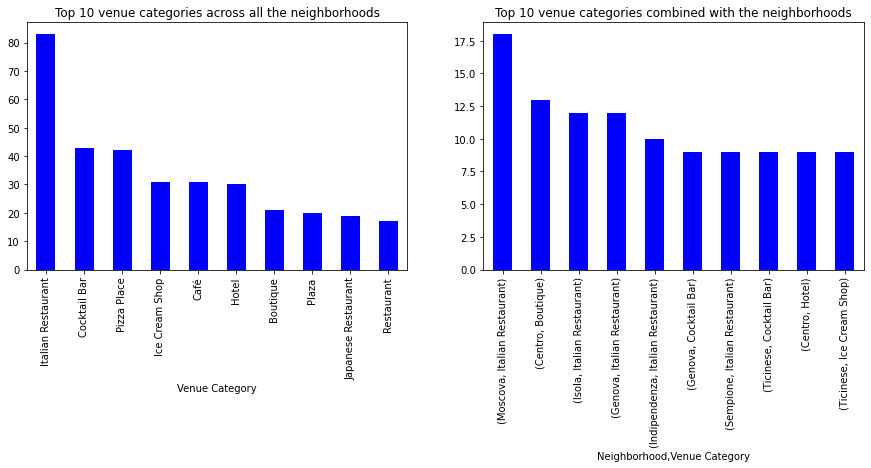

In [40]:
fig = plt.figure()

ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2) 

Milan_venues[['Venue Category','Venue']]\
                        .groupby('Venue Category',as_index=True).count()\
                        .sort_values('Venue',ascending=False).head(10)\
                        .plot(kind='bar',color='blue', figsize=(12, 6), legend=False, ax=ax0)
Milan_venues[['Neighborhood','Venue Category','Venue']]\
                        .groupby(['Neighborhood','Venue Category'],as_index=True).count()\
                        .sort_values('Venue',ascending=False).head(10)\
                        .plot(kind='bar', color='blue', figsize=(15, 10), legend=False, ax=ax1)

ax0.set_title('Top 10 venue categories across all the neighborhoods')
ax1.set_title('Top 10 venue categories combined with the neighborhoods')

plt.show()

Above I show the top 10 venue categories, and the top 10 neighborhood/venue category combinations. Food dominates with Italian restaurants and cocktail bars, but we also have hotels and boutiques. We should be able to cluster **neighborhoods characterised by lifestyle, shopping, and hotel districts.**

I'll use the **onehot encoding** to obtain the dataframe for clustering.

In [41]:
Milan_onehot = pd.get_dummies(Milan_venues[['Venue Category']], prefix="", prefix_sep="")

Milan_onehot['Neighborhood'] = Milan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Milan_onehot.columns[-1]] + list(Milan_onehot.columns[:-1])
Milan_onehot = Milan_onehot[fixed_columns]

Milan_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Theater,Trail,Tram Station,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Susa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Susa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Susa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Susa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Susa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
Milan_onehot.shape

(705, 148)

In [43]:
Milan_grouped = Milan_onehot.groupby('Neighborhood').mean().reset_index()
Milan_grouped.head(10)

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Theater,Trail,Tram Station,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Cenisio,0.00,0.000000,0.000000,0.00,0.050000,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
1,Centro,0.00,0.000000,0.000000,0.00,0.020000,0.03,0.01,0.010000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01
2,Genova,0.00,0.000000,0.000000,0.00,0.022472,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.011236,0.011236,0.011236,0.000000,0.000000,0.000000,0.000000,0.00
3,Indipendenza,0.00,0.000000,0.020408,0.00,0.000000,0.00,0.00,0.020408,0.00,...,0.020408,0.000000,0.000000,0.020408,0.000000,0.000000,0.020408,0.020408,0.000000,0.00
4,Isola,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,...,0.000000,0.012821,0.000000,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.00
5,Moscova,0.00,0.000000,0.000000,0.01,0.010000,0.00,0.00,0.010000,0.01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.010000,0.00
6,Palestro,0.05,0.000000,0.000000,0.00,0.050000,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05
7,Quadronno,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,...,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096774,0.000000,0.00
8,Sempione,0.00,0.014085,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.00
9,Susa,0.00,0.000000,0.000000,0.00,0.032258,0.00,0.00,0.000000,0.00,...,0.000000,0.000000,0.032258,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

I calculate the **5 top most common venues** for each of the 11 selected neighborhoods.

In [45]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Milan_grouped['Neighborhood']

for ind in np.arange(Milan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Milan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(11)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Cenisio,Pizza Place,Hotel,Gym / Fitness Center,Thai Restaurant,Seafood Restaurant
1,Centro,Boutique,Hotel,Italian Restaurant,Plaza,Ice Cream Shop
2,Genova,Italian Restaurant,Cocktail Bar,Pizza Place,Seafood Restaurant,Bar
3,Indipendenza,Italian Restaurant,Ice Cream Shop,Pizza Place,Café,Dessert Shop
4,Isola,Italian Restaurant,Pizza Place,Café,Bistro,Cocktail Bar
5,Moscova,Italian Restaurant,Ice Cream Shop,Wine Bar,Café,Restaurant
6,Palestro,Boutique,Cocktail Bar,Women's Store,Plaza,Art Gallery
7,Quadronno,Wine Bar,Hotel,Pizza Place,Salad Place,Café
8,Sempione,Italian Restaurant,Pizza Place,Cocktail Bar,Japanese Restaurant,Ice Cream Shop
9,Susa,Italian Restaurant,Hotel,Ice Cream Shop,Café,Convenience Store


**Clustering**.

In [46]:
# drop the Neighborhood column
Milan_grouped_clustering = Milan_grouped.drop('Neighborhood', axis= 1)

I use **GridSearchCV** to find the optimal parameters for KMeans.

In [47]:
from sklearn.model_selection import GridSearchCV

clfKM=KMeans()
params={'init':['k-means++','random'],'n_clusters':[3,4,5,6,7,8],'random_state':[0,1]}
grid = GridSearchCV(estimator = clfKM,param_grid=params,cv=5)
grid.fit(Milan_grouped_clustering)
grid.best_params_

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'init': 'random', 'n_clusters': 3, 'random_state': 0}

I use the **elbow method and inertia** to confirm the value for k.

1 : 0.15433067951800716
2 : 0.13132684809628417
3 : 0.1110428194104256
4 : 0.10171499882427999
5 : 0.08012158222517417
6 : 0.06865209864139478
7 : 0.057815844016000824
8 : 0.037258877337318516
9 : 0.02749715295412951
1 : 0.283307259696829
2 : 0.20779774468471374
3 : 0.1375956445944293
4 : 0.11691564371562521
5 : 0.08664242195928833
6 : 0.0643848441523231
7 : 0.05139993170173933
8 : 0.033727743452708944
9 : 0.023005692017313714


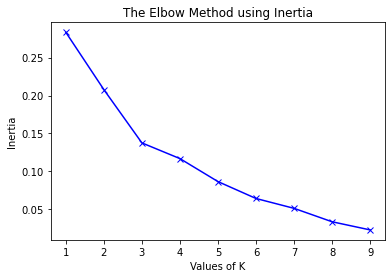

In [48]:
#distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

X = Milan_grouped_clustering
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(init = 'random', n_clusters = k, random_state=0)
    kmeanModel.fit(X)     
      
    #distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
    #                 'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))
    
#plt.plot(K, distortions, 'bx-') 
#plt.xlabel('Values of K') 
#plt.ylabel('Distortion') 
#plt.title('The Elbow Method using Distortion') 
#plt.show()

for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val))

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

**Clustering with K=3.**

In [49]:
# run k-means clustering
kclusters = 3
kmeans = KMeans(init = 'random', n_clusters = kclusters, random_state=0)
kmeans.fit(Milan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 0, 0, 0, 0, 1, 2, 0, 0], dtype=int32)

I obtain the resulting dataframe with the **cluster labels.**

In [50]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge to add latitude/longitude for each neighborhood
df_final_venues = df_final_selection.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how='right') # right join

df_final_venues.head(10)

,Neighborhood,Parking,Zip,Latitude,Longitude,RE_index,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Susa,1,20133,45.467484,9.223430,4.792,0,Italian Restaurant,Hotel,Ice Cream Shop,Café,Convenience Store
1,Sempione,1,20154,45.477104,9.170177,5.984,0,Italian Restaurant,Pizza Place,Cocktail Bar,Japanese Restaurant,Ice Cream Shop
2,Quadronno,1,20136,45.454182,9.191743,8.465,2,Wine Bar,Hotel,Pizza Place,Salad Place,Café
3,Moscova,1,20121,45.477091,9.184342,8.745,0,Italian Restaurant,Ice Cream Shop,Wine Bar,Café,Restaurant
4,Palestro,1,20121,45.471006,9.201477,8.465,1,Boutique,Cocktail Bar,Women's Store,Plaza,Art Gallery
5,Cenisio,1,20154,45.487565,9.172265,5.647,2,Pizza Place,Hotel,Gym / Fitness Center,Thai Restaurant,Seafood Restaurant
6,Isola,1,20159,45.487565,9.188972,5.647,0,Italian Restaurant,Pizza Place,Café,Bistro,Cocktail Bar
7,Indipendenza,1,20129,45.468429,9.213323,6.622,0,Italian Restaurant,Ice Cream Shop,Pizza Place,Café,Dessert Shop
8,Genova,1,20144,45.452879,9.169715,7.534,0,Italian Restaurant,Cocktail Bar,Pizza Place,Seafood Restaurant,Bar
9,Centro,1,10122,45.466800,9.190500,9.947,1,Boutique,Hotel,Italian Restaurant,Plaza,Ice Cream Shop


In [51]:
# create map
map_clusters = folium.Map([milan_center[0],milan_center[1]], zoom_start=12)


latlons_car_sharing = [[lat, lon] for lat, lon in df_car_sharing[['Latitude','Longitude']].values]
HeatMap(latlons_car_sharing).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, index in zip(df_final_venues['Latitude'], 
                                         df_final_venues['Longitude'], 
                                         df_final_venues['Neighborhood'], 
                                         df_final_venues['Cluster Labels'], 
                                         df_final_venues['RE_index']):
    label = folium.Popup(str(poi) + ' , cluster ' + str(cluster) + ', real estate index: ' + '{:.5}'.format(str(index)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

Above is how the **clusters show on a map. The heatmap instead shows the density of the parking areas for car sharing.** A popup for each cluster shows the **neighborhood name, the cluster, and the real estate index.**

I show below the final clusters.

In [52]:
Cluster0=df_final_venues.loc[df_final_venues['Cluster Labels'] == 0, df_final_venues.columns[[0]+ list(range(3, df_final_venues.shape[1]))]]
Cluster0

,Neighborhood,Latitude,Longitude,RE_index,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Susa,45.467484,9.223430,4.792,0,Italian Restaurant,Hotel,Ice Cream Shop,Café,Convenience Store
1,Sempione,45.477104,9.170177,5.984,0,Italian Restaurant,Pizza Place,Cocktail Bar,Japanese Restaurant,Ice Cream Shop
3,Moscova,45.477091,9.184342,8.745,0,Italian Restaurant,Ice Cream Shop,Wine Bar,Café,Restaurant
6,Isola,45.487565,9.188972,5.647,0,Italian Restaurant,Pizza Place,Café,Bistro,Cocktail Bar
7,Indipendenza,45.468429,9.213323,6.622,0,Italian Restaurant,Ice Cream Shop,Pizza Place,Café,Dessert Shop
8,Genova,45.452879,9.169715,7.534,0,Italian Restaurant,Cocktail Bar,Pizza Place,Seafood Restaurant,Bar
10,Ticinese,45.450596,9.181951,7.534,0,Ice Cream Shop,Cocktail Bar,Italian Restaurant,Café,Pizza Place


In [53]:
Cluster0.to_csv('Cluster0.csv')

In [54]:
Cluster1=df_final_venues.loc[df_final_venues['Cluster Labels'] == 1, df_final_venues.columns[[0]+ list(range(3, df_final_venues.shape[1]))]]
Cluster1

,Neighborhood,Latitude,Longitude,RE_index,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Palestro,45.471006,9.201477,8.465,1,Boutique,Cocktail Bar,Women's Store,Plaza,Art Gallery
9,Centro,45.466800,9.190500,9.947,1,Boutique,Hotel,Italian Restaurant,Plaza,Ice Cream Shop


In [55]:
Cluster2=df_final_venues.loc[df_final_venues['Cluster Labels'] == 2, df_final_venues.columns[[0]+ list(range(3, df_final_venues.shape[1]))]]
Cluster2

,Neighborhood,Latitude,Longitude,RE_index,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Quadronno,45.454182,9.191743,8.465,2,Wine Bar,Hotel,Pizza Place,Salad Place,Café
5,Cenisio,45.487565,9.172265,5.647,2,Pizza Place,Hotel,Gym / Fitness Center,Thai Restaurant,Seafood Restaurant


I create a function which, for each cluster, returns the top 5 venues which more than 5 occurrences.

In [56]:
def Get_categories_hist_top5 (cluster):
    
    Milan_venues_grouped=Milan_venues[['Neighborhood','Venue Category','Venue']]\
                                .groupby(['Neighborhood','Venue Category'],as_index=False).count()\
                                .sort_values('Venue',ascending=False)

    Milan_venues_grouped_cl=Milan_venues_grouped[Milan_venues_grouped['Neighborhood'].isin(cluster['Neighborhood'])]

    Milan_venues_grouped_cl_hist=Milan_venues_grouped_cl[['Venue Category','Venue']]\
                                        .groupby('Venue Category').sum()\
                                        .sort_values('Venue',ascending=False)
    
    return(Milan_venues_grouped_cl_hist.head().plot(kind='bar', figsize=(12, 6),legend=False))

I show the top 5 venues for each cluster.

<AxesSubplot:xlabel='Venue Category'>

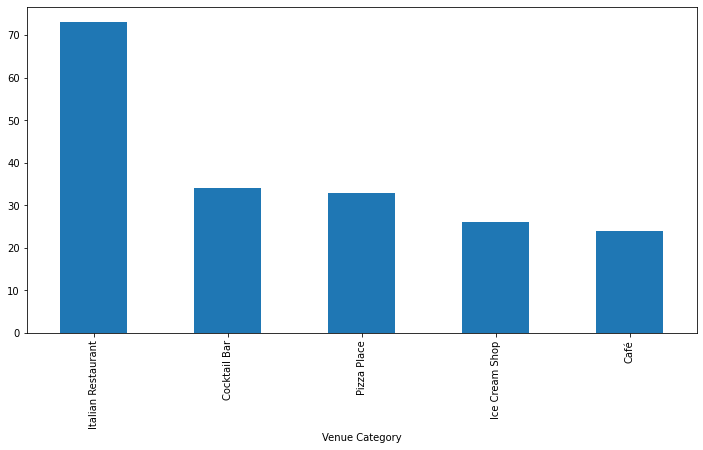

In [57]:
Get_categories_hist_top5(Cluster0)

Cluster 0 is primarily a **lifestyle area.** Looking at the map, the neighborhoods **Sempione, Indipendenza, Isola and Susa are suburbs and show a lower real estate index. Moscova is central and expensive, Porta Genova and Ticinese are still central and lifestyle.**

<AxesSubplot:xlabel='Venue Category'>

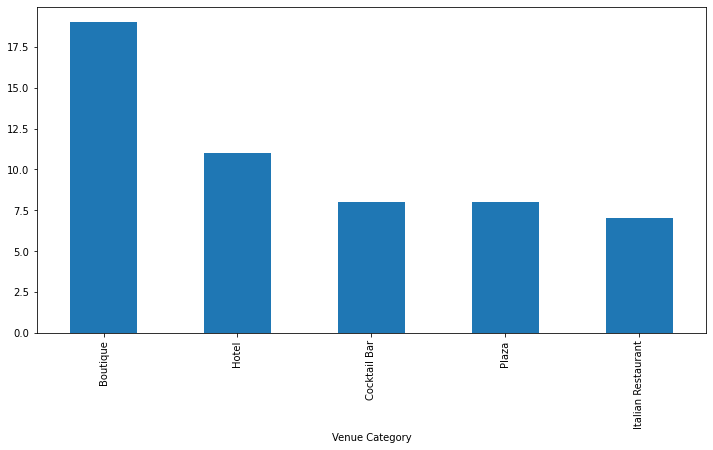

In [58]:
Get_categories_hist_top5(Cluster1)

Cluster 1 is primarily a **shopping district**, it's smaller in terms of venues that cluster Zero. **The neighborhoods are clearly central and have a high real estate index.**

<AxesSubplot:xlabel='Venue Category'>

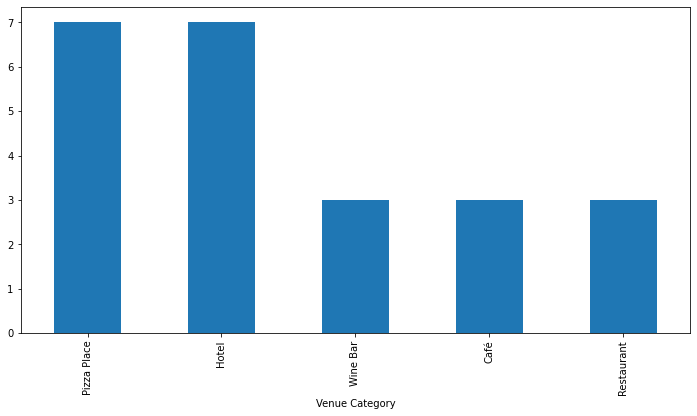

In [59]:
Get_categories_hist_top5(Cluster2)

Cluster 2 is primarily a **suburb hospitality area** and it's smaller in terms of venues than cluster Zero and One. The neighborhoods are different because **Cenisio is suburbs and has a low real estate index, while Quadronno is still central and has a high real estate index.**

## Results and Discussion <a name="results"></a>

The analysis shows that although parking areas for car sharing are present in the center of Milan (~3Km), there are zones of low parking spot density, no more than  1 in range of 300m, fairly close to city center. The Highest concentration of parking areas was detected East and close to the city center. I focused my attention to areas **East and less close to the city center (Indipendenza, Susa)** because they also **combine a lower real estate value.** Similarly, other neighborhoods were identified as potentially interesting **North from the city center (Cenisio, Sempione, Isola).**

The neighborhood of Cenisio is close to hotels and intercepts traffic arriving from North, North West (Malpensa airport, directions arriving from the A8 and A9 highways -Switzerland). The neighborhood of Sempione and Isola (lifestyle) are near Cenisio, and Sempione is actually slightly closer to the city center. The neighborhoods of Indipendenza and Susa, both lifestyle, intercept traffic arriving from East (Linate airport, Bergamo airport and directions along the A4 highway -Venice).

Those neighborhoods candidates were  clustered to create zones of interest. They will become starting points for more detailed local analysis based on other factors. As I learned during the course, this does not imply that those zones are actually optimal locations for a new parking area. It is possible that there is a very good reason for small number of parking for car sharing in any of those areas, regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in locations which have not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Milan **areas within 3Km from the city center with no more than 1 parking area for car sharing within a 300m radius.** This will help the stakeholders to narrow down the search for optimal location for new parking areas. Clustering of those neighborhoods was then performed in order to create major zones of interest which will be used as starting points for final exploration by stakeholders.

A final decision on optimal parking areas location will be made by stakeholders based on specific characteristics of neighborhoods in every recommended zone, taking into consideration additional factors.